In [1]:
# read the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

grid = pd.read_pickle("outputs_in_instab_strip.pkl")

In [2]:
# then we have to first create the X and y matrices.

l_values = [0, 1, 2] 
l_columns = {l: [col for col in grid.columns if col.endswith(f"_l_{l}")] for l in l_values}

X_frequencies = np.hstack([grid[l_columns[l]].values for l in l_values])  
delta_nu_values = grid["delta_nu"].values[:, np.newaxis] 
mod_frequencies = X_frequencies % delta_nu_values 

X = np.stack((X_frequencies, mod_frequencies), axis=-1)
y = np.hstack([np.full_like(grid[l_columns[l]].values, l) for l in l_values])  

print(f"X-matrix shape: {X.shape}")
print(f"y-matrix shape: {y.shape}") 

X-matrix shape: (153314, 30, 2)
y-matrix shape: (153314, 30)


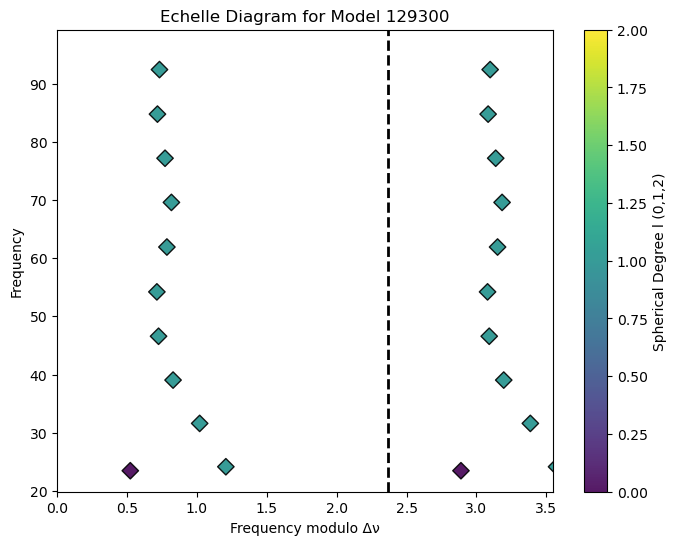

In [3]:
# again this is just for fun and to see that we can still plot the echelle diagrams

ii = np.random.randint(0, 153314)

fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

sc = ax.scatter(X[ii, :, 1], X[ii, :, 0], marker='D', c=y[ii], cmap="viridis", edgecolors='black', alpha=0.9, s=70)
ax.scatter(X[ii, :, 1] + grid.loc[ii, 'delta_nu'], X[ii, :, 0], marker='D', c=y[ii], cmap="viridis", edgecolors='black', alpha=0.9, s=70)
ax.axvline(grid.loc[ii, 'delta_nu'], color='black', linestyle='--', linewidth=2)
ax.set_xlim(0, grid.loc[ii, 'delta_nu']*1.5)
plt.colorbar(sc, label="Spherical Degree l (0,1,2)")
plt.xlabel("Frequency modulo Δν")
plt.ylabel("Frequency")
plt.title(f"Echelle Diagram for Model {ii}")

plt.show()

In [4]:
from sklearn.model_selection import train_test_split
import torch

# Convert data to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)  # Assuming y contains class labels

# Split the data (80% train, 10% val, 10% test)
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print shape
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

Train: torch.Size([122651, 30, 2]), Validation: torch.Size([15331, 30, 2]), Test: torch.Size([15332, 30, 2])


In [5]:
size = 10000 # or for all models it would be: X_train.shape[0]
inpt = X_train[:size]
print(inpt.shape)

torch.Size([10000, 30, 2])


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class PointNet(nn.Module):
    def __init__(self, num_classes=3, point_dimension=2, dropout=0.3):
        super(PointNet, self).__init__()

        self.conv_1 = nn.Conv1d(point_dimension, 64, 1)
        self.conv_2 = nn.Conv1d(64, 64, 1)
        self.bn_1 = nn.BatchNorm1d(64)
        self.bn_2 = nn.BatchNorm1d(64)

    def forward(self, x, plot=False):
        #batch_size, num_channels, num_points = x.shape  # x shape: [batch, 2, num_points]
        num_points = x.shape[1]
        #print(x.shape)
        x = x.transpose(2, 1) 
        
        # Feature Extraction
        x = F.relu(self.bn_1(self.conv_1(x)))
        #print(x.shape)
        x = F.relu(self.bn_2(self.conv_2(x)))
        
        x = nn.MaxPool1d(num_points)(x)  
        #print(x.shape)
        return x
        
class SegmentationPointNet(nn.Module):
    def __init__(self, num_classes, point_dimension=2, dropout=0.3):
        super(SegmentationPointNet, self).__init__()
        self.base_pointnet = PointNet(point_dimension=point_dimension)

        # Per-point classification layers
        self.fc_1 = nn.Linear(66, 16)
        self.fc_2 = nn.Linear(16, 3)

    def forward(self, x):
        global_features = self.base_pointnet(x)  # Extract per-point features, shape: [batch, 256, num_points]
        #print(global_features.shape)
        global_features = global_features.transpose(2,1)
        global_features = global_features.repeat(1, x.shape[1], 1)
        x = torch.cat((x, global_features), dim=2)
        # need to paste the global features after the individual points as inputs for the segmentation (classification each point in the cloud)
        x = F.relu(self.fc_1(x)) 

        return F.log_softmax(self.fc_2(x), dim=2)

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class PointNet(nn.Module):
    def __init__(self, num_classes=3, point_dimension=2, dropout=0.3):
        super(PointNet, self).__init__()
        
        a=3
        nfeat=128
        
        self.conv_1 = nn.Conv1d(point_dimension, nfeat, a, padding=2)
        self.conv_2 = nn.Conv1d(nfeat, nfeat, a, padding=2)
        self.bn_1 = nn.BatchNorm1d(nfeat)
        self.bn_2 = nn.BatchNorm1d(nfeat)

    def forward(self, x, plot=False):
        num_points = x.shape[1]
        x = x.transpose(2, 1)
        x = F.relu(self.bn_1(self.conv_1(x)))
        x = F.relu(self.bn_2(self.conv_2(x)))
        x = nn.MaxPool1d(num_points)(x)
        return x

class SegmentationPointNet(nn.Module):
    def __init__(self, num_classes, point_dimension=2, dropout=0.3):
        super(SegmentationPointNet, self).__init__()
        self.base_pointnet = PointNet(point_dimension=point_dimension)

        nhidden=64
        nfeat=128
        
        self.fc_1 = nn.Linear(nfeat+2, nhidden)
        self.fc_2 = nn.Linear(nhidden, 3)

    def forward(self, x):
        global_features = self.base_pointnet(x)
        global_features = global_features.transpose(2, 1)
        global_features = global_features.repeat(1, x.shape[1], 1)
        x = torch.cat((x, global_features), dim=2)
        x = F.relu(self.fc_1(x))
        return F.log_softmax(self.fc_2(x), dim=2)

In [21]:
model = SegmentationPointNet(num_classes=3, point_dimension=2)
loss = nn.NLLLoss()

In [22]:
out = model(inpt)

In [23]:
# define some crap


history_train, history_test = [], []
Nepoch = 80
nbatches = 100
learning_rate = 0.001
batch_size = inpt.size()[0]//nbatches 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

target_test = y_train[:size]
target = y_train[:size]
inpt_test = inpt

for epoch in range(Nepoch):
    for i in range(nbatches):
        optimizer.zero_grad()

        output = model(inpt[i*batch_size:(i+1)*batch_size])
        cost = loss(output.permute(0, 2, 1), target[i*batch_size:(i+1)*batch_size])

        cost.backward() # backward is a pytorch command apparently
        optimizer.step()

    out_test = model(inpt_test)
    cost_test = loss(out_test.permute(0, 2, 1), target_test)
    history_train.append(float(cost))
    history_test.append(float(cost_test))
    print('epoch %i'%epoch, float(cost), float(cost_test))

epoch 0 1.0129698514938354 1.0074145793914795
epoch 1 0.924689531326294 0.9120526313781738
epoch 2 0.8305712938308716 0.8110671043395996


KeyboardInterrupt: 

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
i_data = 50
l = 1  # which mode (l=0,1,2) to plot probability for

# Get the data
freqs = inpt.detach().numpy()[i_data, :, 1]
powers = inpt.detach().numpy()[i_data, :, 0]
true_labels = y_train.detach().numpy()[i_data]
probs = out_test.exp().detach().numpy()[i_data, :, l]

# === First figure: True labels with custom legend ===
fig1 = plt.figure(figsize=(6, 5), dpi=120)
plt.scatter(freqs, powers, c=true_labels, cmap='viridis', vmin=0, vmax=2)

legend_elements = [
    mpatches.Patch(color=plt.cm.viridis(0.0), label='l = 0'),
    mpatches.Patch(color=plt.cm.viridis(0.5), label='l = 1'),
    mpatches.Patch(color=plt.cm.viridis(1.0), label='l = 2'),
]
plt.legend(handles=legend_elements, title="True l-mode", loc="upper right")
plt.title("True Mode Labels")
plt.xlabel(r"Frequency modulo $\Delta \nu$ (d$^{-1}$)")
plt.ylabel(r"Frequency (d$^{-1}$)")

# === Second figure: Predicted probability for l ===
fig2 = plt.figure(figsize=(6, 5), dpi=120)
sc = plt.scatter(freqs, powers, c=probs, cmap='viridis', vmin=0.0, vmax=1.0)

# Add text labels slightly to the right of each point
for x, y, p in zip(freqs, powers, probs):
    plt.text(x + 0.08, y, f"{p:.2f}", fontsize=7, color="black", ha='left', va='center')

cbar = plt.colorbar(sc)
cbar.set_label(f"Probabilities for l = {l}", fontsize=11, labelpad=10)
cbar.ax.tick_params(labelsize=10)
plt.title(f"Predicted Probabilities (l = {l})")
plt.xlabel(r"Frequency modulo $\Delta \nu$ (d$^{-1}$)")
plt.ylabel(r"Frequency (d$^{-1}$)")
plt.tight_layout()
plt.show()

NameError: name 'inpt' is not defined

In [15]:
print(out_test.shape)

torch.Size([10000, 30, 3])


In [16]:
loss_fn = nn.NLLLoss()
loss = loss_fn(out_test.transpose(2,1), y_train[:size])

In [17]:
print(loss)

tensor(0.3149, grad_fn=<NllLoss2DBackward0>)
